<a href="https://colab.research.google.com/github/egonloch/DNC/blob/main/Desafio_7_Egon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Business Understanding

Uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, você precisa agrupar os clientes em clusters com base em
seu comportamento de compra.
- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.

Os dados fornecidos possuem informações de transações de compras de uma loja de
e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de
540.000 transações.

# Step 2 : Data Understanding

## Setup

In [1]:
%%capture
%pip install sidetable

In [2]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

In [3]:
# customização dos graficos
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

In [5]:
# carregar o dataset
df = pd.read_csv('https://www.notion.so/signed/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fe73c934e-cd3a-4e00-85f6-b704762fec77%2Fdata.csv?table=block&id=e9f1a77d-e0db-46c4-8ef0-c79064da3c0e&spaceId=6a055055-52ec-4ebb-a697-63027c951344&userId=c0845f00-59fb-4a0f-bb4a-c1e2314cd202&cache=v2', encoding='latin1')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data understanding

In [6]:
#verificar o tipo das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
#verificar se existe dados com letras
df.InvoiceNo.sort_values()

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

In [10]:
#verificar a quantidade valores unicos de países e descriçoes
df[['Description','Country']].nunique()

Description    4223
Country          38
dtype: int64

In [13]:
#verificar valores negativos
df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


<Axes: ylabel='Country'>

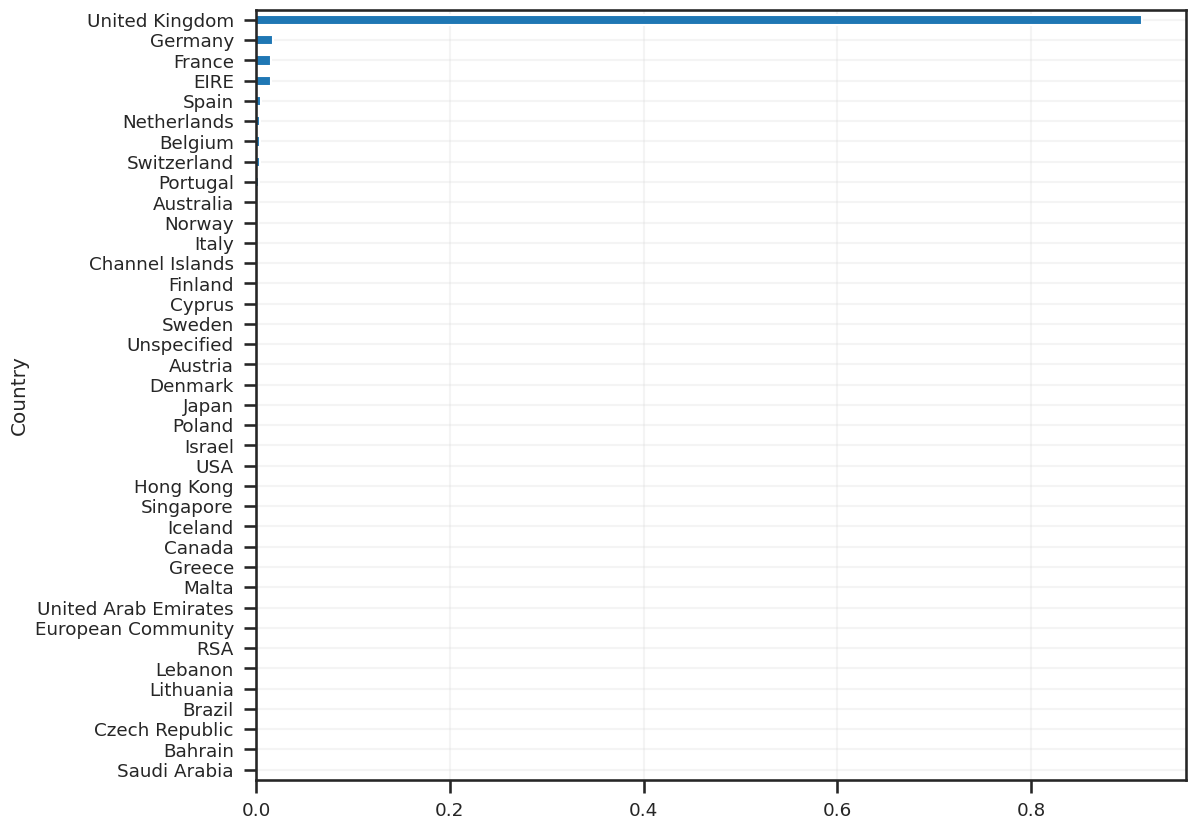

In [15]:
#quantidade em cada país
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10))

In [14]:
#frequencia de cada país
df.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [18]:
#verificar valores faltantes
df.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [17]:
#verificar valores duplicados
df.duplicated().sum()

5268

# Step 3 : Data Preparation